# Import thu vien

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=da729f813821159d06e97d91d4e67002c517d36241c6e82100e4b2b1b6022300
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=927658f1260aefa6443b3489c301eb2e46ad78b8a213eae894f6bcdc6f0b18ad
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import timm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test

[0 1 2 3 4]


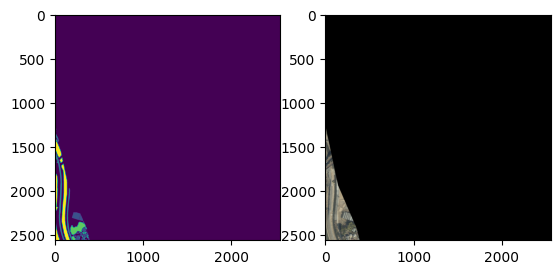

In [4]:
mask_path = "/content/drive/MyDrive/NAVER/Mask2_resample/Mask_Row(250)_Col(322)_resample.tif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img_path = "/content/drive/MyDrive/NAVER/TrueOrtho_resample/Ortho_Row(250)_Col(322)_resample.tif"
img= cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(img)
print(np.unique(mask))

# Tao CustomDataset

In [5]:
class CustomDataset(Dataset):
  def __init__(self, root_dir, txt_file, transform = None):
    super().__init__()
    self.root_dir = root_dir
    self.txt_file= txt_file
    self.transform = transform
    self.img_path_list = []
    with open(self.txt_file) as file_in:
      for line in file_in:
        self.img_path_list.append(line)

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    filename = self.img_path_list[idx]
    base, ext = os.path.splitext(filename)
    resample_filename1 = f"{base}{ext}"
    base2 = base.replace('Ortho', 'Mask')
    resample_filename2 = f"{base2}{ext}"

    image_path = os.path.join(self.root_dir,"TrueOrtho_resample", resample_filename1.strip())
    mask_path = os.path.join(self.root_dir,"Mask2_resample", resample_filename2.strip())
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if self.transform is not None:
      transformed = self.transform(image = image, mask = mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

# Augmentation anh

In [6]:
train_transformed = A.Compose([
    A.Resize(width=720, height=720),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.GaussNoise(), # Added Gaussian noise
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03), # Added elastic transform
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transformed = A.Compose([
    A.Resize(width=1024, height=1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

val_transformed = A.Compose([
    A.Resize(width=720, height=720),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


In [7]:
train_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/train.txt", train_transformed)
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)
val_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/val.txt", val_transformed)
train_dataset.__getitem__(98)


(tensor([[[ 0.6392,  0.6221,  0.5878,  ..., -0.0458,  0.3994,  0.5878],
          [ 0.6563,  0.6221,  0.5707,  ..., -0.1657,  0.2282,  0.4166],
          [ 0.6906,  0.6906,  0.6734,  ..., -0.2684,  0.0056,  0.2282],
          ...,
          [-1.4329, -1.4500, -1.4500,  ..., -1.3987, -1.3987, -1.3815],
          [-1.4329, -1.4500, -1.4500,  ..., -1.3987, -1.3987, -1.3815],
          [-1.4158, -1.4500, -1.4500,  ..., -1.3987, -1.3987, -1.3815]],
 
         [[ 0.7129,  0.6779,  0.6429,  ..., -0.1450,  0.0826,  0.2052],
          [ 0.7479,  0.6954,  0.6254,  ..., -0.1625,  0.0126,  0.1001],
          [ 0.8354,  0.8179,  0.7654,  ..., -0.1975, -0.0749, -0.0049],
          ...,
          [-0.7577, -0.7752, -0.7752,  ..., -0.7402, -0.7402, -0.7402],
          [-0.7577, -0.7752, -0.7752,  ..., -0.7402, -0.7402, -0.7402],
          [-0.7577, -0.7752, -0.7752,  ..., -0.7402, -0.7402, -0.7402]],
 
         [[ 0.6879,  0.6531,  0.6182,  ..., -0.1312,  0.1128,  0.2348],
          [ 0.7402,  0.6705,

In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


# U Net model

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Tinh Accuracy

In [10]:
def accuracy_function(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    acc_class = []
    for i in range(5):  # Assuming 2 classes
        indices = targets_flat == i
        total = indices.sum().item()
        if total > 0:
            correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
            acc_class.append(correct / total)
    return sum(acc_class) / len(acc_class) if acc_class else 0

def calculate_recall(intersection, target):
    # Recall = TP / (TP + FN)
    # In this case, TP is the intersection and FN is target - intersection
    recall = intersection / (target - intersection + 1e-10)
    return recall

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [11]:
from transformers import SegformerForSemanticSegmentation
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 2
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
#model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640").to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 200
#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
recall_meter = AverageMeter()
target_meter = AverageMeter()

val_loss_meter = AverageMeter()
val_intersection_meter = AverageMeter()
val_union_meter = AverageMeter()
val_target_meter = AverageMeter()

num_workers = 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

# Train

In [12]:
from torch.cuda.amp import GradScaler, autocast

# Initialize the gradient scaler
scaler = GradScaler()

# Set the number of accumulation steps
accumulation_steps = 16 # Adjust this value according to your memory limit

best_val_loss = float('inf')
train_losses =[]
val_losses = []
accuracy_list =[]
best_epoch_preds, best_epoch_targets = None, None

for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    recall_meter.reset()
    model.train()

    optimizer.zero_grad()  # Reset gradients tensors

    #training loop
    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()

        # Runs the forward pass with autocasting.
        with autocast():
            y_hat = model(x).logits #(B, C, H, W)
            y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
            loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
            loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # Backward passes without optimization every few batches
        if (batch_id + 1) % accumulation_steps == 0:
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item() * accumulation_steps)  # We have to scale our loss back
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 5)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 2D
        accuracy = intersection_meter.sum / (target_meter.sum + 1e-10) #vector 2D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)

        mIoU = torch.mean(iou_class) #mean vector 2D
        mAcc = torch.mean(accuracy) #mean vector 2D
        mDice = torch.mean(dice_class)
        accuracy_list.append(mAcc.item())

    train_losses.append(train_loss_meter.avg)
    #Validation Loop
    val_loss_meter.reset()
    val_intersection_meter.reset()
    val_union_meter.reset()
    val_target_meter.reset()
    model.eval()

    with torch.no_grad():
        for x,y in valloader:
            n = x.shape[0]
            x = x.to(device).float()
            y = y.to(device).long()
            y_hat = model(x).logits
            y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
            loss = criterion(y_hat, y)

            #save metrics
            val_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 5)
            val_intersection_meter.update(intersection)
            val_union_meter.update(union)
            val_target_meter.update(target)

        #compute iou, dice
        iou_class = val_intersection_meter.sum / (val_union_meter.sum + 1e-10)
        accuracy = val_intersection_meter.sum / (val_target_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)

        mIoU = torch.mean(iou_class)
        mAcc = torch.mean(accuracy)
        mDice = torch.mean(dice_class)

    val_loss = val_loss_meter.avg
    val_losses.append(val_loss_meter.avg)
    print("EP {}, val loss = {:.5f}".format(ep, val_loss_meter.avg))
    print("EP {}, train loss = {:.5f} IoU = {:.5f}, Accuracy = {:.5f}, Dice= {:.5f}".format(ep, train_loss_meter.avg, mIoU, mAcc, mDice))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/best_model.pth")
        best_epoch_preds = y_hat.argmax(dim=1).squeeze().cpu().numpy()
        best_epoch_targets = y.squeeze().cpu().numpy()


100%|██████████| 55/55 [02:14<00:00,  2.44s/it]


EP 1, val loss = 4.49692
EP 1, train loss = 3.67751 IoU = 0.17479, Accuracy = 0.22150, Dice= 0.19868


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 2, val loss = 3.43792
EP 2, train loss = 2.34734 IoU = 0.16510, Accuracy = 0.18347, Dice= 0.27652


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


EP 3, val loss = 1.71705
EP 3, train loss = 1.75773 IoU = 0.24186, Accuracy = 0.30864, Dice= 0.28160


100%|██████████| 55/55 [00:50<00:00,  1.09it/s]


EP 4, val loss = 0.95703
EP 4, train loss = 1.46973 IoU = 0.30449, Accuracy = 0.38976, Dice= 0.29856


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 5, val loss = 0.43026
EP 5, train loss = 1.28474 IoU = 0.41307, Accuracy = 0.51968, Dice= 0.32405


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 6, val loss = 0.28751
EP 6, train loss = 1.18959 IoU = 0.44287, Accuracy = 0.53961, Dice= 0.39483


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 7, val loss = 0.24008
EP 7, train loss = 1.03728 IoU = 0.45955, Accuracy = 0.53414, Dice= 0.44979


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 8, val loss = 0.21692
EP 8, train loss = 0.96349 IoU = 0.47919, Accuracy = 0.56761, Dice= 0.48096


100%|██████████| 55/55 [00:50<00:00,  1.09it/s]


EP 9, val loss = 0.20357
EP 9, train loss = 0.92187 IoU = 0.50710, Accuracy = 0.60778, Dice= 0.49837


100%|██████████| 55/55 [00:54<00:00,  1.02it/s]


EP 10, val loss = 0.19522
EP 10, train loss = 0.89337 IoU = 0.51646, Accuracy = 0.61211, Dice= 0.52270


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 11, val loss = 0.19305
EP 11, train loss = 0.88834 IoU = 0.51350, Accuracy = 0.59811, Dice= 0.52611


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 12, val loss = 0.19511
EP 12, train loss = 0.80398 IoU = 0.51228, Accuracy = 0.60486, Dice= 0.53572


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


EP 13, val loss = 0.19859
EP 13, train loss = 0.78949 IoU = 0.50639, Accuracy = 0.59337, Dice= 0.53222


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 14, val loss = 0.19070
EP 14, train loss = 0.83456 IoU = 0.52691, Accuracy = 0.63591, Dice= 0.52383


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 15, val loss = 0.18788
EP 15, train loss = 0.76782 IoU = 0.53338, Accuracy = 0.65485, Dice= 0.55710


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 16, val loss = 0.18308
EP 16, train loss = 0.76777 IoU = 0.53811, Accuracy = 0.63453, Dice= 0.55056


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 17, val loss = 0.19285
EP 17, train loss = 0.73992 IoU = 0.52662, Accuracy = 0.61002, Dice= 0.55835


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 18, val loss = 0.18930
EP 18, train loss = 0.70772 IoU = 0.54186, Accuracy = 0.64502, Dice= 0.56686


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 19, val loss = 0.19508
EP 19, train loss = 0.72158 IoU = 0.55261, Accuracy = 0.64679, Dice= 0.56665


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 20, val loss = 0.18664
EP 20, train loss = 0.69566 IoU = 0.56198, Accuracy = 0.70174, Dice= 0.57202


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 21, val loss = 0.17759
EP 21, train loss = 0.69646 IoU = 0.55769, Accuracy = 0.69182, Dice= 0.58517


100%|██████████| 55/55 [00:50<00:00,  1.08it/s]


EP 22, val loss = 0.17508
EP 22, train loss = 0.66669 IoU = 0.55770, Accuracy = 0.68695, Dice= 0.59282


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 23, val loss = 0.17190
EP 23, train loss = 0.70729 IoU = 0.55541, Accuracy = 0.66562, Dice= 0.58819


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 24, val loss = 0.17016
EP 24, train loss = 0.67371 IoU = 0.56613, Accuracy = 0.67900, Dice= 0.59088


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 25, val loss = 0.17061
EP 25, train loss = 0.68462 IoU = 0.55807, Accuracy = 0.66907, Dice= 0.58735


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 26, val loss = 0.17692
EP 26, train loss = 0.65636 IoU = 0.55148, Accuracy = 0.66980, Dice= 0.60763


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 27, val loss = 0.18955
EP 27, train loss = 0.66538 IoU = 0.54794, Accuracy = 0.69277, Dice= 0.60790


100%|██████████| 55/55 [00:54<00:00,  1.02it/s]


EP 28, val loss = 0.17634
EP 28, train loss = 0.64353 IoU = 0.57556, Accuracy = 0.69255, Dice= 0.60992


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 29, val loss = 0.16253
EP 29, train loss = 0.61848 IoU = 0.56923, Accuracy = 0.69008, Dice= 0.61056


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 30, val loss = 0.17217
EP 30, train loss = 0.62644 IoU = 0.57186, Accuracy = 0.69622, Dice= 0.60868


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 31, val loss = 0.17196
EP 31, train loss = 0.60115 IoU = 0.56831, Accuracy = 0.70341, Dice= 0.63026


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 32, val loss = 0.16896
EP 32, train loss = 0.63099 IoU = 0.57390, Accuracy = 0.68899, Dice= 0.61989


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 33, val loss = 0.17911
EP 33, train loss = 0.61947 IoU = 0.56826, Accuracy = 0.66994, Dice= 0.61988


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 34, val loss = 0.18915
EP 34, train loss = 0.61466 IoU = 0.56557, Accuracy = 0.67022, Dice= 0.61942


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 35, val loss = 0.17533
EP 35, train loss = 0.60666 IoU = 0.56657, Accuracy = 0.68850, Dice= 0.62233


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 36, val loss = 0.18564
EP 36, train loss = 0.59591 IoU = 0.56919, Accuracy = 0.66494, Dice= 0.62836


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 37, val loss = 0.16826
EP 37, train loss = 0.60005 IoU = 0.58302, Accuracy = 0.66462, Dice= 0.59319


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 38, val loss = 0.17912
EP 38, train loss = 0.60271 IoU = 0.58664, Accuracy = 0.67330, Dice= 0.62592


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 39, val loss = 0.19032
EP 39, train loss = 0.57835 IoU = 0.59303, Accuracy = 0.70500, Dice= 0.63300


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 40, val loss = 0.17188
EP 40, train loss = 0.59510 IoU = 0.59657, Accuracy = 0.71766, Dice= 0.62794


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 41, val loss = 0.16999
EP 41, train loss = 0.57857 IoU = 0.58870, Accuracy = 0.69080, Dice= 0.63804


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 42, val loss = 0.17089
EP 42, train loss = 0.57320 IoU = 0.58364, Accuracy = 0.68913, Dice= 0.63846


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 43, val loss = 0.16418
EP 43, train loss = 0.58350 IoU = 0.58679, Accuracy = 0.70352, Dice= 0.64042


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 44, val loss = 0.15711
EP 44, train loss = 0.57938 IoU = 0.59240, Accuracy = 0.71466, Dice= 0.64056


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 45, val loss = 0.15912
EP 45, train loss = 0.56223 IoU = 0.60117, Accuracy = 0.69732, Dice= 0.64174


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 46, val loss = 0.15034
EP 46, train loss = 0.56929 IoU = 0.60597, Accuracy = 0.72580, Dice= 0.64312


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 47, val loss = 0.16063
EP 47, train loss = 0.56258 IoU = 0.59989, Accuracy = 0.71386, Dice= 0.64757


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 48, val loss = 0.16234
EP 48, train loss = 0.55586 IoU = 0.59346, Accuracy = 0.70885, Dice= 0.65407


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 49, val loss = 0.16474
EP 49, train loss = 0.56276 IoU = 0.59524, Accuracy = 0.70274, Dice= 0.64077


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 50, val loss = 0.17002
EP 50, train loss = 0.55939 IoU = 0.58896, Accuracy = 0.71019, Dice= 0.64577


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 51, val loss = 0.16675
EP 51, train loss = 0.55205 IoU = 0.59461, Accuracy = 0.71835, Dice= 0.65442


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 52, val loss = 0.17301
EP 52, train loss = 0.54428 IoU = 0.58994, Accuracy = 0.69436, Dice= 0.65563


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 53, val loss = 0.15621
EP 53, train loss = 0.54161 IoU = 0.58968, Accuracy = 0.71118, Dice= 0.64550


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 54, val loss = 0.15729
EP 54, train loss = 0.54884 IoU = 0.59814, Accuracy = 0.73939, Dice= 0.65948


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 55, val loss = 0.15210
EP 55, train loss = 0.55202 IoU = 0.58973, Accuracy = 0.70440, Dice= 0.65824


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 56, val loss = 0.16000
EP 56, train loss = 0.54042 IoU = 0.59562, Accuracy = 0.71473, Dice= 0.65824


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 57, val loss = 0.16132
EP 57, train loss = 0.54448 IoU = 0.59298, Accuracy = 0.71337, Dice= 0.65086


100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


EP 58, val loss = 0.16087
EP 58, train loss = 0.54663 IoU = 0.60007, Accuracy = 0.72009, Dice= 0.65476


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 59, val loss = 0.15213
EP 59, train loss = 0.52719 IoU = 0.60442, Accuracy = 0.74941, Dice= 0.66350


100%|██████████| 55/55 [00:54<00:00,  1.02it/s]


EP 60, val loss = 0.15128
EP 60, train loss = 0.53490 IoU = 0.60637, Accuracy = 0.72686, Dice= 0.66271


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 61, val loss = 0.14739
EP 61, train loss = 0.52703 IoU = 0.60961, Accuracy = 0.73033, Dice= 0.65930


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 62, val loss = 0.15620
EP 62, train loss = 0.54470 IoU = 0.61315, Accuracy = 0.72312, Dice= 0.65137


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 63, val loss = 0.15358
EP 63, train loss = 0.52202 IoU = 0.60270, Accuracy = 0.74314, Dice= 0.66649


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 64, val loss = 0.15099
EP 64, train loss = 0.54037 IoU = 0.60326, Accuracy = 0.73557, Dice= 0.66081


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 65, val loss = 0.15083
EP 65, train loss = 0.52544 IoU = 0.61494, Accuracy = 0.73401, Dice= 0.66901


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 66, val loss = 0.14666
EP 66, train loss = 0.52359 IoU = 0.62054, Accuracy = 0.74344, Dice= 0.66381


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 67, val loss = 0.15204
EP 67, train loss = 0.51714 IoU = 0.61477, Accuracy = 0.75516, Dice= 0.66628


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 68, val loss = 0.14394
EP 68, train loss = 0.52147 IoU = 0.61611, Accuracy = 0.71315, Dice= 0.67289


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 69, val loss = 0.13052
EP 69, train loss = 0.53349 IoU = 0.61362, Accuracy = 0.68943, Dice= 0.66125


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 70, val loss = 0.14985
EP 70, train loss = 0.52019 IoU = 0.61492, Accuracy = 0.72338, Dice= 0.66528


100%|██████████| 55/55 [00:51<00:00,  1.08it/s]


EP 71, val loss = 0.14232
EP 71, train loss = 0.51726 IoU = 0.61488, Accuracy = 0.76015, Dice= 0.67512


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 72, val loss = 0.13759
EP 72, train loss = 0.51666 IoU = 0.61665, Accuracy = 0.72853, Dice= 0.67438


100%|██████████| 55/55 [00:49<00:00,  1.11it/s]


EP 73, val loss = 0.12983
EP 73, train loss = 0.51518 IoU = 0.62284, Accuracy = 0.71029, Dice= 0.66287


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 74, val loss = 0.13648
EP 74, train loss = 0.52007 IoU = 0.62823, Accuracy = 0.73459, Dice= 0.65708


100%|██████████| 55/55 [00:50<00:00,  1.08it/s]


EP 75, val loss = 0.14003
EP 75, train loss = 0.51099 IoU = 0.62760, Accuracy = 0.75523, Dice= 0.68074


100%|██████████| 55/55 [00:50<00:00,  1.08it/s]


EP 76, val loss = 0.13514
EP 76, train loss = 0.51150 IoU = 0.63059, Accuracy = 0.75072, Dice= 0.67658


100%|██████████| 55/55 [00:50<00:00,  1.10it/s]


EP 77, val loss = 0.13716
EP 77, train loss = 0.49571 IoU = 0.63010, Accuracy = 0.72519, Dice= 0.67405


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 78, val loss = 0.13116
EP 78, train loss = 0.49812 IoU = 0.63470, Accuracy = 0.75354, Dice= 0.67268


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 79, val loss = 0.12393
EP 79, train loss = 0.49780 IoU = 0.63812, Accuracy = 0.75891, Dice= 0.68025


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 80, val loss = 0.13512
EP 80, train loss = 0.49995 IoU = 0.64586, Accuracy = 0.75778, Dice= 0.68605


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 81, val loss = 0.12446
EP 81, train loss = 0.50021 IoU = 0.63460, Accuracy = 0.73005, Dice= 0.67665


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 82, val loss = 0.12316
EP 82, train loss = 0.49475 IoU = 0.64022, Accuracy = 0.75402, Dice= 0.67436


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 83, val loss = 0.11990
EP 83, train loss = 0.49213 IoU = 0.63905, Accuracy = 0.72517, Dice= 0.68559


100%|██████████| 55/55 [00:51<00:00,  1.08it/s]


EP 84, val loss = 0.11948
EP 84, train loss = 0.50013 IoU = 0.63589, Accuracy = 0.70955, Dice= 0.68037


100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


EP 85, val loss = 0.12766
EP 85, train loss = 0.49126 IoU = 0.64117, Accuracy = 0.73713, Dice= 0.67766


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


EP 86, val loss = 0.11823
EP 86, train loss = 0.49809 IoU = 0.64548, Accuracy = 0.74718, Dice= 0.67771


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 87, val loss = 0.12331
EP 87, train loss = 0.49337 IoU = 0.64476, Accuracy = 0.73958, Dice= 0.68565


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 88, val loss = 0.11127
EP 88, train loss = 0.48495 IoU = 0.64146, Accuracy = 0.72102, Dice= 0.67805


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 89, val loss = 0.11802
EP 89, train loss = 0.48905 IoU = 0.64169, Accuracy = 0.75747, Dice= 0.68467


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 90, val loss = 0.11257
EP 90, train loss = 0.48601 IoU = 0.64611, Accuracy = 0.73869, Dice= 0.68768


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 91, val loss = 0.10985
EP 91, train loss = 0.48946 IoU = 0.64266, Accuracy = 0.72161, Dice= 0.68046


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 92, val loss = 0.12075
EP 92, train loss = 0.47781 IoU = 0.65145, Accuracy = 0.75321, Dice= 0.68687


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 93, val loss = 0.11761
EP 93, train loss = 0.49183 IoU = 0.65017, Accuracy = 0.75341, Dice= 0.68747


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 94, val loss = 0.11851
EP 94, train loss = 0.48325 IoU = 0.64641, Accuracy = 0.72728, Dice= 0.68677


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 95, val loss = 0.12673
EP 95, train loss = 0.47787 IoU = 0.65240, Accuracy = 0.74561, Dice= 0.68343


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 96, val loss = 0.12233
EP 96, train loss = 0.47861 IoU = 0.65276, Accuracy = 0.75384, Dice= 0.69625


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 97, val loss = 0.11673
EP 97, train loss = 0.48565 IoU = 0.65488, Accuracy = 0.74727, Dice= 0.69351


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 98, val loss = 0.11623
EP 98, train loss = 0.47496 IoU = 0.65521, Accuracy = 0.75081, Dice= 0.69662


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 99, val loss = 0.11922
EP 99, train loss = 0.47343 IoU = 0.65768, Accuracy = 0.76608, Dice= 0.69763


100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


EP 100, val loss = 0.12367
EP 100, train loss = 0.48367 IoU = 0.65437, Accuracy = 0.75197, Dice= 0.69057


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 101, val loss = 0.11941
EP 101, train loss = 0.47783 IoU = 0.65352, Accuracy = 0.75708, Dice= 0.69474


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 102, val loss = 0.11792
EP 102, train loss = 0.47663 IoU = 0.65721, Accuracy = 0.76252, Dice= 0.68962


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


EP 103, val loss = 0.12085
EP 103, train loss = 0.47909 IoU = 0.65660, Accuracy = 0.75238, Dice= 0.69717


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 104, val loss = 0.12401
EP 104, train loss = 0.46833 IoU = 0.65707, Accuracy = 0.75120, Dice= 0.70026


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 105, val loss = 0.13116
EP 105, train loss = 0.47290 IoU = 0.66022, Accuracy = 0.76673, Dice= 0.69118


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 106, val loss = 0.12765
EP 106, train loss = 0.47619 IoU = 0.65828, Accuracy = 0.76297, Dice= 0.69016


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 107, val loss = 0.11488
EP 107, train loss = 0.47411 IoU = 0.65986, Accuracy = 0.75543, Dice= 0.69520


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 108, val loss = 0.11872
EP 108, train loss = 0.47103 IoU = 0.66079, Accuracy = 0.77168, Dice= 0.69839


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 109, val loss = 0.12342
EP 109, train loss = 0.46799 IoU = 0.66158, Accuracy = 0.78006, Dice= 0.69836


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 110, val loss = 0.11968
EP 110, train loss = 0.46931 IoU = 0.66192, Accuracy = 0.77131, Dice= 0.69530


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 111, val loss = 0.12546
EP 111, train loss = 0.45963 IoU = 0.66162, Accuracy = 0.77899, Dice= 0.70241


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 112, val loss = 0.12018
EP 112, train loss = 0.46572 IoU = 0.66340, Accuracy = 0.78301, Dice= 0.69523


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 113, val loss = 0.12038
EP 113, train loss = 0.46067 IoU = 0.66389, Accuracy = 0.77638, Dice= 0.70572


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 114, val loss = 0.12181
EP 114, train loss = 0.45492 IoU = 0.66308, Accuracy = 0.76490, Dice= 0.70002


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 115, val loss = 0.12829
EP 115, train loss = 0.46123 IoU = 0.66406, Accuracy = 0.77989, Dice= 0.69905


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 116, val loss = 0.12523
EP 116, train loss = 0.45945 IoU = 0.66709, Accuracy = 0.77845, Dice= 0.70456


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 117, val loss = 0.11371
EP 117, train loss = 0.46082 IoU = 0.66776, Accuracy = 0.76463, Dice= 0.69777


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 118, val loss = 0.10697
EP 118, train loss = 0.46288 IoU = 0.66792, Accuracy = 0.77345, Dice= 0.69667


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 119, val loss = 0.11838
EP 119, train loss = 0.45821 IoU = 0.66693, Accuracy = 0.77435, Dice= 0.70778


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 120, val loss = 0.11951
EP 120, train loss = 0.45717 IoU = 0.66746, Accuracy = 0.76143, Dice= 0.70068


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 121, val loss = 0.12024
EP 121, train loss = 0.45789 IoU = 0.67035, Accuracy = 0.77621, Dice= 0.69974


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 122, val loss = 0.12777
EP 122, train loss = 0.45865 IoU = 0.66918, Accuracy = 0.77758, Dice= 0.70690


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 123, val loss = 0.11936
EP 123, train loss = 0.45291 IoU = 0.66205, Accuracy = 0.74904, Dice= 0.70694


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 124, val loss = 0.11747
EP 124, train loss = 0.45860 IoU = 0.66698, Accuracy = 0.76328, Dice= 0.69930


100%|██████████| 55/55 [00:51<00:00,  1.08it/s]


EP 125, val loss = 0.11641
EP 125, train loss = 0.45263 IoU = 0.66756, Accuracy = 0.75804, Dice= 0.70864


100%|██████████| 55/55 [00:55<00:00,  1.01s/it]


EP 126, val loss = 0.11454
EP 126, train loss = 0.46074 IoU = 0.66893, Accuracy = 0.76267, Dice= 0.70100


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 127, val loss = 0.11586
EP 127, train loss = 0.45199 IoU = 0.67006, Accuracy = 0.76704, Dice= 0.70464


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 128, val loss = 0.11935
EP 128, train loss = 0.45688 IoU = 0.67034, Accuracy = 0.76600, Dice= 0.68698


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 129, val loss = 0.12849
EP 129, train loss = 0.45369 IoU = 0.66516, Accuracy = 0.76602, Dice= 0.70433


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 130, val loss = 0.12741
EP 130, train loss = 0.46093 IoU = 0.66352, Accuracy = 0.75058, Dice= 0.70748


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 131, val loss = 0.11997
EP 131, train loss = 0.45168 IoU = 0.66365, Accuracy = 0.74120, Dice= 0.70495


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 132, val loss = 0.11930
EP 132, train loss = 0.45618 IoU = 0.66397, Accuracy = 0.75175, Dice= 0.70247


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 133, val loss = 0.11878
EP 133, train loss = 0.44926 IoU = 0.66429, Accuracy = 0.75448, Dice= 0.71076


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 134, val loss = 0.12070
EP 134, train loss = 0.45247 IoU = 0.66266, Accuracy = 0.73752, Dice= 0.70774


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 135, val loss = 0.11602
EP 135, train loss = 0.45604 IoU = 0.66567, Accuracy = 0.75295, Dice= 0.70116


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 136, val loss = 0.11950
EP 136, train loss = 0.44668 IoU = 0.66852, Accuracy = 0.76739, Dice= 0.71057


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 137, val loss = 0.11529
EP 137, train loss = 0.44046 IoU = 0.66331, Accuracy = 0.74137, Dice= 0.71506


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 138, val loss = 0.11289
EP 138, train loss = 0.44707 IoU = 0.66532, Accuracy = 0.74234, Dice= 0.70636


100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


EP 139, val loss = 0.10940
EP 139, train loss = 0.44768 IoU = 0.67188, Accuracy = 0.77229, Dice= 0.70703


100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


EP 140, val loss = 0.10634
EP 140, train loss = 0.44628 IoU = 0.67245, Accuracy = 0.75411, Dice= 0.71102


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 141, val loss = 0.10422
EP 141, train loss = 0.44115 IoU = 0.67226, Accuracy = 0.75292, Dice= 0.71450


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 142, val loss = 0.10607
EP 142, train loss = 0.44221 IoU = 0.67154, Accuracy = 0.77011, Dice= 0.71606


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 143, val loss = 0.10548
EP 143, train loss = 0.44475 IoU = 0.67031, Accuracy = 0.75282, Dice= 0.71182


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 144, val loss = 0.11277
EP 144, train loss = 0.44329 IoU = 0.67394, Accuracy = 0.75691, Dice= 0.71002


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 145, val loss = 0.11523
EP 145, train loss = 0.43456 IoU = 0.67450, Accuracy = 0.78192, Dice= 0.71555


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 146, val loss = 0.11158
EP 146, train loss = 0.44551 IoU = 0.67331, Accuracy = 0.76104, Dice= 0.71735


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 147, val loss = 0.10696
EP 147, train loss = 0.43938 IoU = 0.67573, Accuracy = 0.76769, Dice= 0.70744


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 148, val loss = 0.10809
EP 148, train loss = 0.43618 IoU = 0.67439, Accuracy = 0.76096, Dice= 0.71467


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 149, val loss = 0.10549
EP 149, train loss = 0.43974 IoU = 0.67164, Accuracy = 0.74281, Dice= 0.71435


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 150, val loss = 0.10050
EP 150, train loss = 0.43940 IoU = 0.67891, Accuracy = 0.76362, Dice= 0.71607


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 151, val loss = 0.10403
EP 151, train loss = 0.44223 IoU = 0.67706, Accuracy = 0.76431, Dice= 0.71395


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 152, val loss = 0.10316
EP 152, train loss = 0.44142 IoU = 0.67306, Accuracy = 0.74465, Dice= 0.71303


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 153, val loss = 0.10300
EP 153, train loss = 0.43782 IoU = 0.67412, Accuracy = 0.74789, Dice= 0.71718


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 154, val loss = 0.10514
EP 154, train loss = 0.43372 IoU = 0.67561, Accuracy = 0.75815, Dice= 0.72028


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 155, val loss = 0.10687
EP 155, train loss = 0.43739 IoU = 0.67378, Accuracy = 0.74791, Dice= 0.71833


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 156, val loss = 0.10299
EP 156, train loss = 0.43979 IoU = 0.68078, Accuracy = 0.76284, Dice= 0.71367


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 157, val loss = 0.10841
EP 157, train loss = 0.43473 IoU = 0.68293, Accuracy = 0.77435, Dice= 0.72170


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 158, val loss = 0.10442
EP 158, train loss = 0.43450 IoU = 0.68022, Accuracy = 0.76464, Dice= 0.71963


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 159, val loss = 0.10432
EP 159, train loss = 0.43423 IoU = 0.67972, Accuracy = 0.75372, Dice= 0.71518


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 160, val loss = 0.11027
EP 160, train loss = 0.43466 IoU = 0.67966, Accuracy = 0.75980, Dice= 0.71442


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 161, val loss = 0.10304
EP 161, train loss = 0.43733 IoU = 0.68227, Accuracy = 0.77320, Dice= 0.71966


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 162, val loss = 0.10377
EP 162, train loss = 0.43278 IoU = 0.67857, Accuracy = 0.75922, Dice= 0.71936


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 163, val loss = 0.10070
EP 163, train loss = 0.43364 IoU = 0.67736, Accuracy = 0.75491, Dice= 0.71269


100%|██████████| 55/55 [00:55<00:00,  1.00s/it]


EP 164, val loss = 0.10898
EP 164, train loss = 0.43179 IoU = 0.68030, Accuracy = 0.76558, Dice= 0.71878


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 165, val loss = 0.10541
EP 165, train loss = 0.43772 IoU = 0.68236, Accuracy = 0.76721, Dice= 0.72056


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 166, val loss = 0.10247
EP 166, train loss = 0.43272 IoU = 0.67916, Accuracy = 0.76107, Dice= 0.72022


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 167, val loss = 0.10146
EP 167, train loss = 0.43489 IoU = 0.68228, Accuracy = 0.77036, Dice= 0.71723


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 168, val loss = 0.10011
EP 168, train loss = 0.42895 IoU = 0.68394, Accuracy = 0.77183, Dice= 0.72471


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 169, val loss = 0.10784
EP 169, train loss = 0.43119 IoU = 0.67969, Accuracy = 0.75991, Dice= 0.72382


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 170, val loss = 0.10622
EP 170, train loss = 0.42756 IoU = 0.67600, Accuracy = 0.75418, Dice= 0.71911


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 171, val loss = 0.10541
EP 171, train loss = 0.42976 IoU = 0.67993, Accuracy = 0.76854, Dice= 0.72137


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 172, val loss = 0.10731
EP 172, train loss = 0.43366 IoU = 0.68101, Accuracy = 0.77244, Dice= 0.72052


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 173, val loss = 0.10735
EP 173, train loss = 0.43086 IoU = 0.67954, Accuracy = 0.76296, Dice= 0.72258


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 174, val loss = 0.10576
EP 174, train loss = 0.43503 IoU = 0.67896, Accuracy = 0.76605, Dice= 0.71817


100%|██████████| 55/55 [00:50<00:00,  1.08it/s]


EP 175, val loss = 0.10710
EP 175, train loss = 0.42694 IoU = 0.67866, Accuracy = 0.75355, Dice= 0.72159


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 176, val loss = 0.10404
EP 176, train loss = 0.43112 IoU = 0.68428, Accuracy = 0.77254, Dice= 0.72257


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 177, val loss = 0.10598
EP 177, train loss = 0.43304 IoU = 0.68050, Accuracy = 0.76411, Dice= 0.71789


100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


EP 178, val loss = 0.10543
EP 178, train loss = 0.42886 IoU = 0.67782, Accuracy = 0.76114, Dice= 0.71818


100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


EP 179, val loss = 0.10869
EP 179, train loss = 0.43513 IoU = 0.67907, Accuracy = 0.75648, Dice= 0.71485


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 180, val loss = 0.10173
EP 180, train loss = 0.42942 IoU = 0.68261, Accuracy = 0.76637, Dice= 0.72354


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 181, val loss = 0.09965
EP 181, train loss = 0.42441 IoU = 0.67812, Accuracy = 0.75484, Dice= 0.72673


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 182, val loss = 0.09806
EP 182, train loss = 0.42812 IoU = 0.68414, Accuracy = 0.76839, Dice= 0.72235


100%|██████████| 55/55 [00:53<00:00,  1.02it/s]


EP 183, val loss = 0.09804
EP 183, train loss = 0.42788 IoU = 0.68823, Accuracy = 0.77818, Dice= 0.72274


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 184, val loss = 0.09974
EP 184, train loss = 0.42110 IoU = 0.68696, Accuracy = 0.77106, Dice= 0.72976


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 185, val loss = 0.10758
EP 185, train loss = 0.42753 IoU = 0.68518, Accuracy = 0.77044, Dice= 0.72606


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 186, val loss = 0.10443
EP 186, train loss = 0.42395 IoU = 0.68477, Accuracy = 0.77391, Dice= 0.72901


100%|██████████| 55/55 [00:52<00:00,  1.06it/s]


EP 187, val loss = 0.10342
EP 187, train loss = 0.42549 IoU = 0.68610, Accuracy = 0.76703, Dice= 0.72786


100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


EP 188, val loss = 0.10172
EP 188, train loss = 0.42804 IoU = 0.68610, Accuracy = 0.76623, Dice= 0.72447


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 189, val loss = 0.10659
EP 189, train loss = 0.42640 IoU = 0.68484, Accuracy = 0.77018, Dice= 0.72646


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 190, val loss = 0.10160
EP 190, train loss = 0.42916 IoU = 0.68681, Accuracy = 0.75724, Dice= 0.72116


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 191, val loss = 0.10664
EP 191, train loss = 0.42220 IoU = 0.69268, Accuracy = 0.77846, Dice= 0.72695


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 192, val loss = 0.10522
EP 192, train loss = 0.42394 IoU = 0.69083, Accuracy = 0.77211, Dice= 0.73083


100%|██████████| 55/55 [00:52<00:00,  1.05it/s]


EP 193, val loss = 0.10926
EP 193, train loss = 0.42602 IoU = 0.68479, Accuracy = 0.75511, Dice= 0.72450


100%|██████████| 55/55 [00:55<00:00,  1.01s/it]


EP 194, val loss = 0.10459
EP 194, train loss = 0.42281 IoU = 0.69329, Accuracy = 0.77762, Dice= 0.72418


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 195, val loss = 0.10561
EP 195, train loss = 0.42111 IoU = 0.69314, Accuracy = 0.78974, Dice= 0.73133


100%|██████████| 55/55 [00:52<00:00,  1.04it/s]


EP 196, val loss = 0.10743
EP 196, train loss = 0.42122 IoU = 0.69125, Accuracy = 0.77106, Dice= 0.73062


100%|██████████| 55/55 [00:53<00:00,  1.04it/s]


EP 197, val loss = 0.10332
EP 197, train loss = 0.42002 IoU = 0.69224, Accuracy = 0.78146, Dice= 0.72947


100%|██████████| 55/55 [00:51<00:00,  1.07it/s]


EP 198, val loss = 0.10578
EP 198, train loss = 0.42234 IoU = 0.68989, Accuracy = 0.77532, Dice= 0.72810


100%|██████████| 55/55 [00:53<00:00,  1.03it/s]


EP 199, val loss = 0.10608
EP 199, train loss = 0.42261 IoU = 0.69146, Accuracy = 0.78335, Dice= 0.72467


100%|██████████| 55/55 [00:51<00:00,  1.06it/s]


EP 200, val loss = 0.10099
EP 200, train loss = 0.42171 IoU = 0.69155, Accuracy = 0.78156, Dice= 0.73059


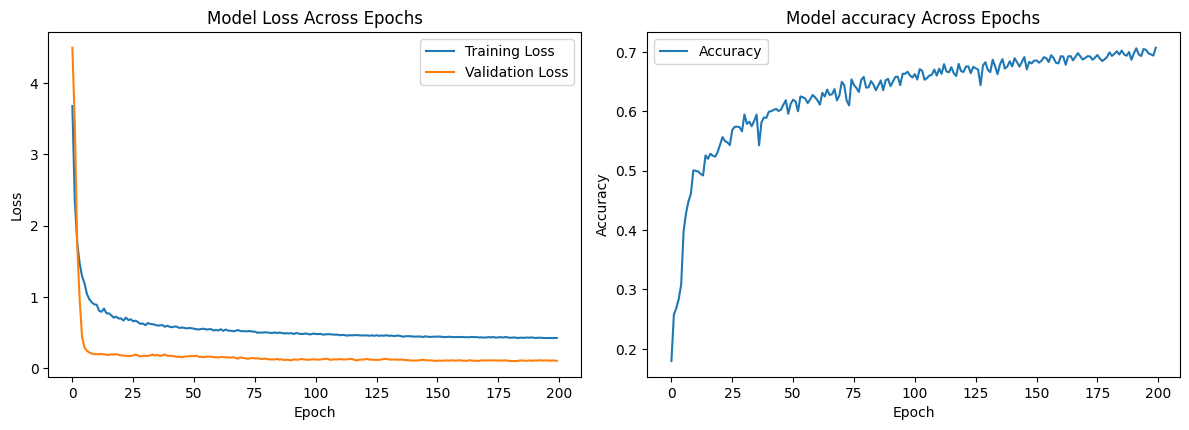

In [13]:
plt.figure(figsize=(12, 8))

# Plotting Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting Dice
plt.subplot(2, 2, 2)
plt.plot(accuracy_list, label='Accuracy')
plt.title('Model accuracy Across Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
test_transformed = A.Compose([
    A.Resize(width=2000, height=2000),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)


# Test

Image ID: 0, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


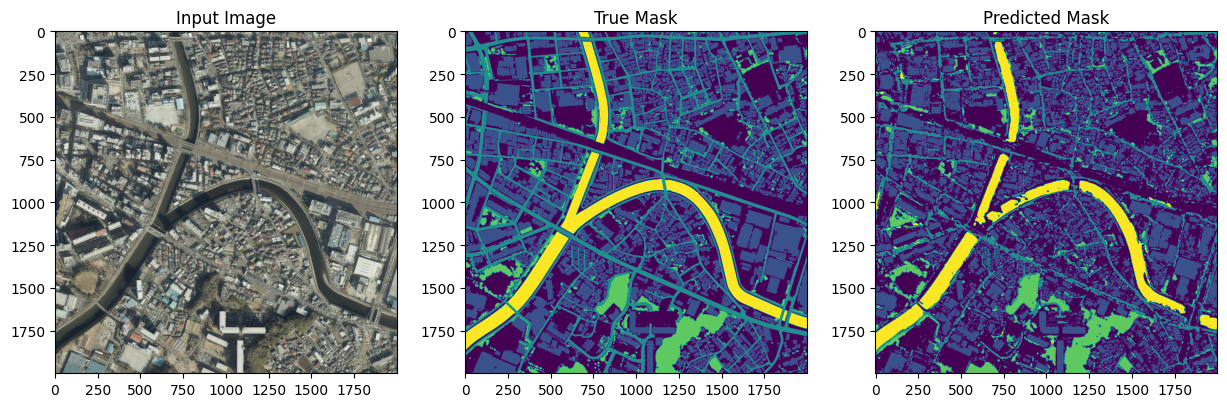

Image ID: 1, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


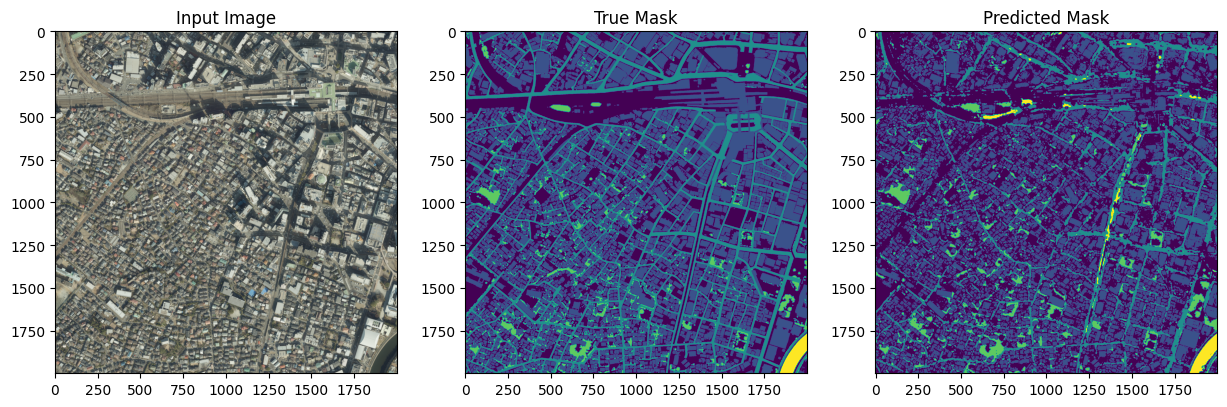

Image ID: 2, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


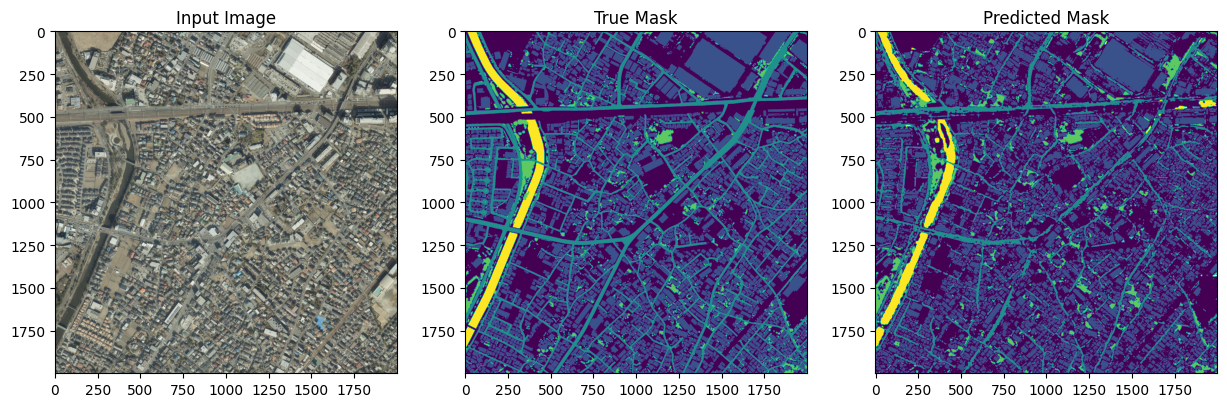

Image ID: 3, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


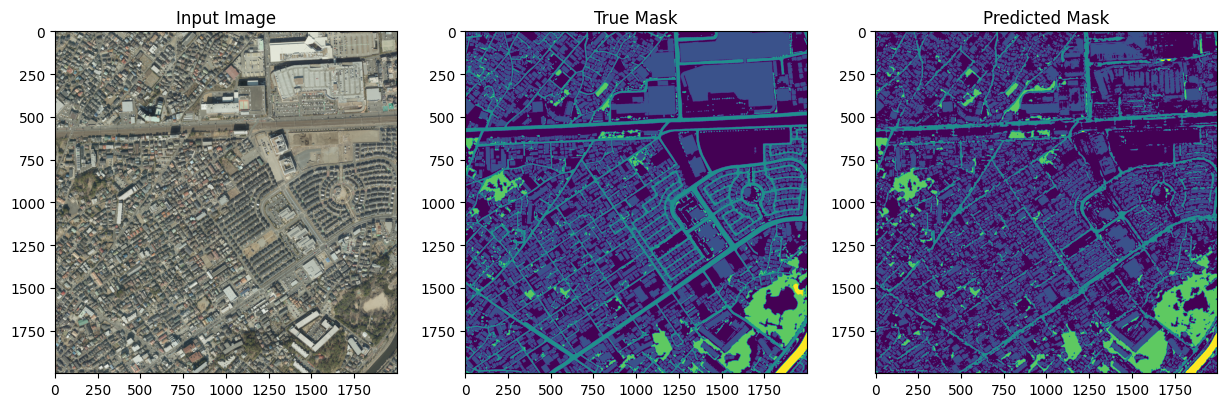

Image ID: 4, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3]
Shape of prediction: (2000, 2000)


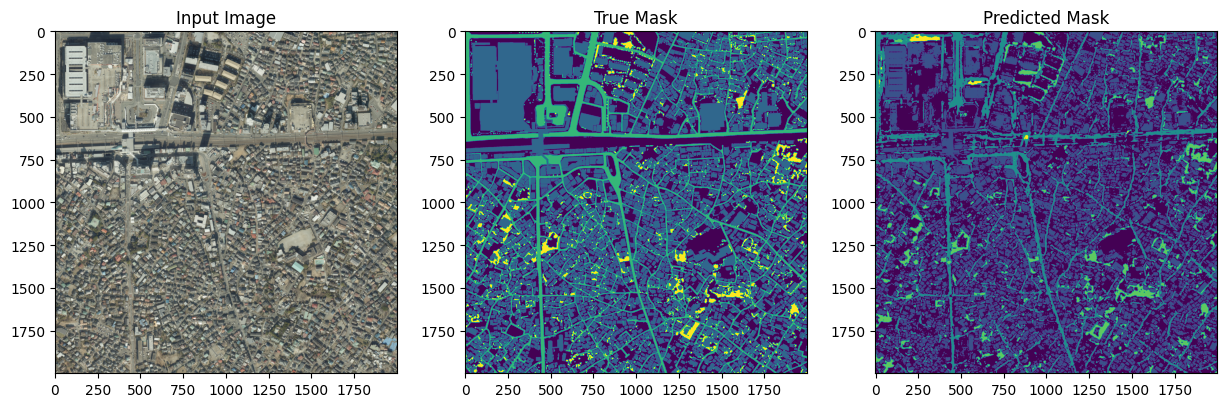

Image ID: 5, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3]
Shape of prediction: (2000, 2000)


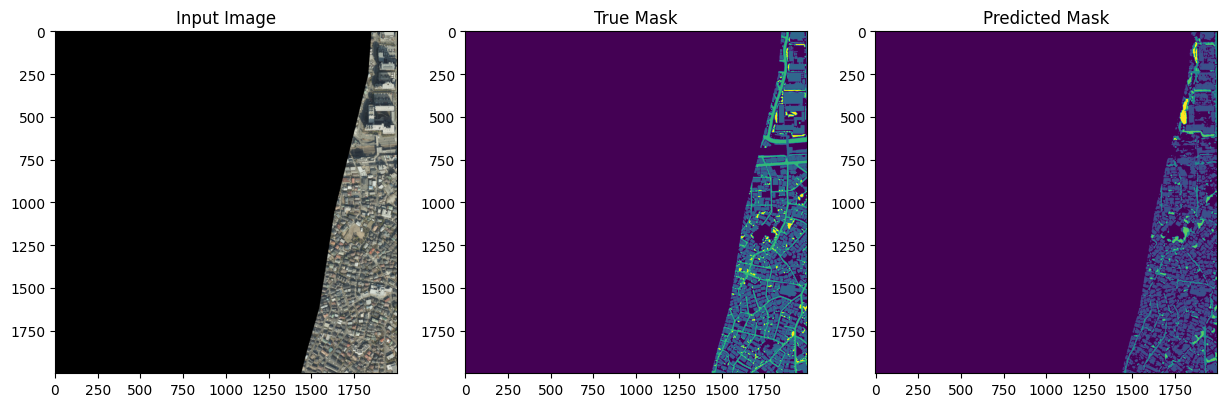

Image ID: 6, Unique values in prediction: [0], Unique values in ground truth: [0]
Shape of prediction: (2000, 2000)


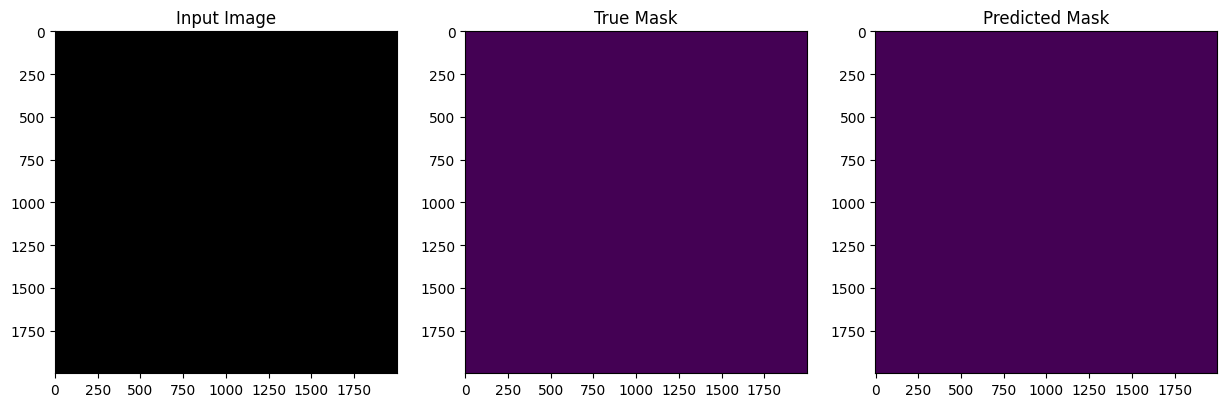

Image ID: 7, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 3]
Shape of prediction: (2000, 2000)


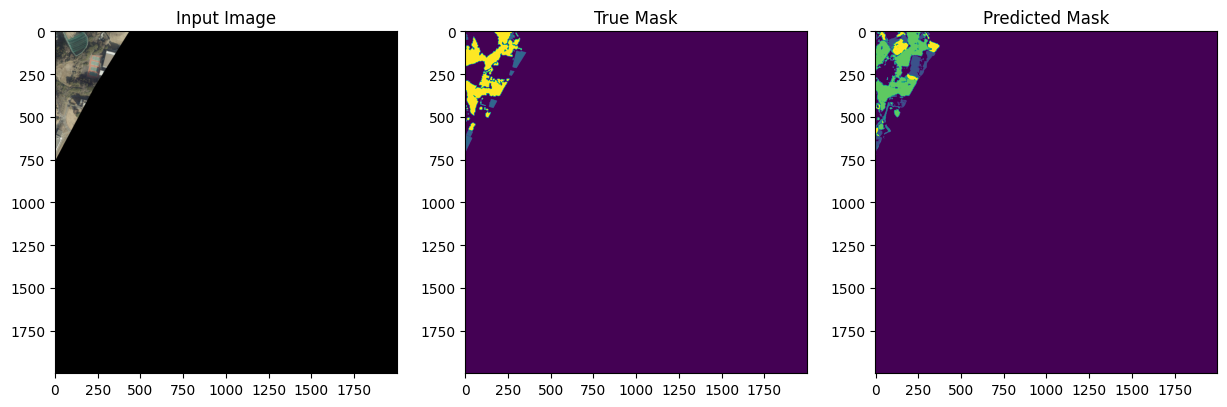

Image ID: 8, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


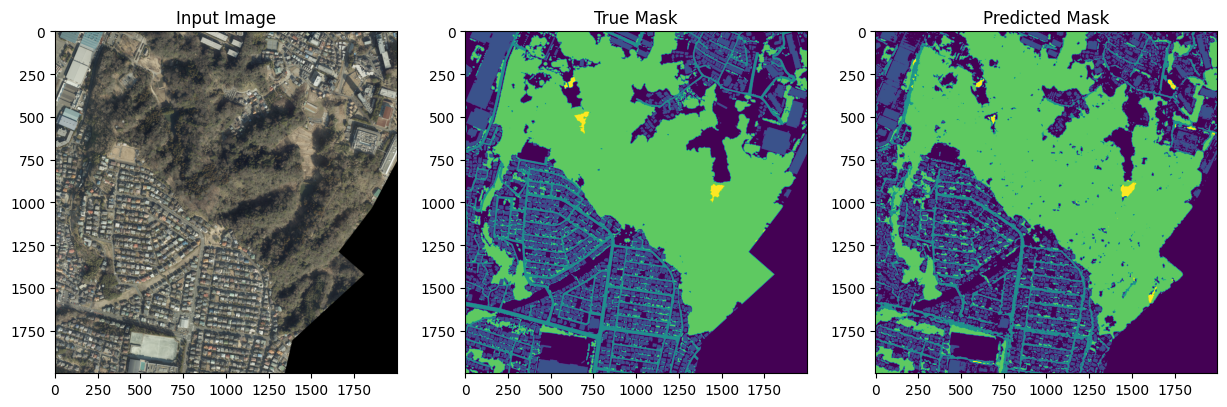

Image ID: 9, Unique values in prediction: [0 1 2 3 4], Unique values in ground truth: [0 1 2 3 4]
Shape of prediction: (2000, 2000)


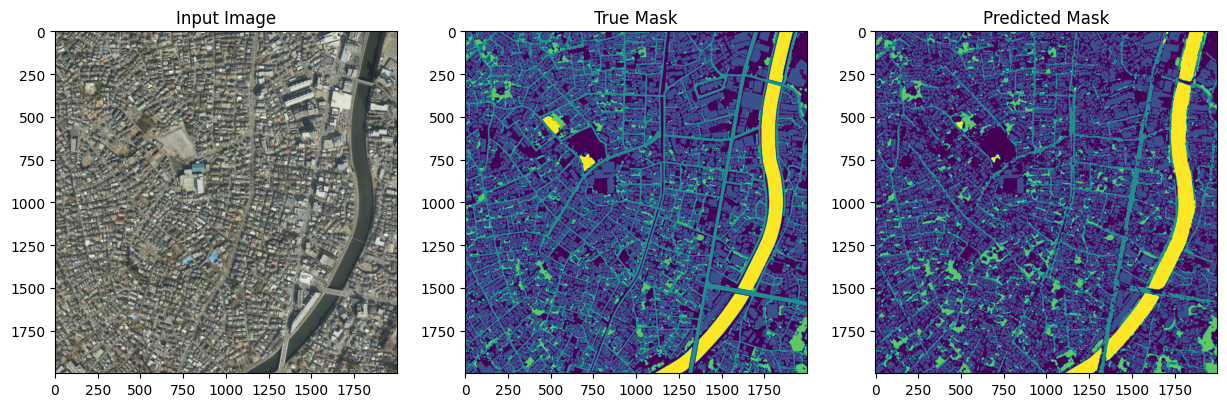

In [23]:
import random
import numpy as np

with torch.no_grad():
    model.eval()
    for id in range(len(test_dataset)):
        x, y = test_dataset.__getitem__(id)
        y_predicted = F.interpolate(model(x.unsqueeze(0).to(device)).logits, size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
        print(f"Image ID: {id}, Unique values in prediction: {np.unique(y_predicted)}, Unique values in ground truth: {np.unique(y)}")
        print(f"Shape of prediction: {y_predicted.shape}")

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots
        axs[0].imshow(unorm(x).cpu().permute(1, 2, 0))  # Display the input image
        axs[0].set_title('Input Image')
        axs[1].imshow(y)  # Display the ground truth mask
        axs[1].set_title('True Mask')
        axs[2].imshow(y_predicted)  # Display the predicted mask
        axs[2].set_title('Predicted Mask')
        plt.show()
